### Lab-10 : Build a recommender system based on Amazon Reviews

Name: Bharat v
    
Roll No: 215229108

**Step.1: Download the dataset** https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

In [1]:
#importing the packages 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("ratings_beauty.csv")
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
#shape of the dataset
print("There are",df.shape[0], "rows and", df.shape[1],"columns.")

There are 2023070 rows and 4 columns.


In [4]:
#info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [5]:
df.describe(include='all')

,UserId,ProductId,Rating,Timestamp
count,2023070,2023070,2.023070e+06,2.023070e+06
unique,1210271,249274,NaN,NaN
top,A3KEZLJ59C1JVH,B001MA0QY2,NaN,NaN
freq,389,7533,NaN,NaN
mean,NaN,NaN,4.149036e+00,1.360389e+09
std,NaN,NaN,1.311505e+00,4.611860e+07
min,NaN,NaN,1.000000e+00,9.087552e+08
25%,NaN,NaN,4.000000e+00,1.350259e+09
50%,NaN,NaN,5.000000e+00,1.372810e+09
75%,NaN,NaN,5.000000e+00,1.391472e+09


In [6]:
# Mean rating for each Product

product_rating = df.groupby('ProductId')['Rating'].mean()
product_rating.head()

ProductId
0205616461    5.0
0558925278    4.0
0733001998    4.0
0737104473    1.0
0762451459    5.0
Name: Rating, dtype: float64

In [7]:
# Count of the number of ratings per Product

product_rating_count = df.groupby('ProductId')['Rating'].count()
product_rating_count.head()

ProductId
0205616461    1
0558925278    2
0733001998    1
0737104473    1
0762451459    1
Name: Rating, dtype: int64

In [8]:
# Un-Reliability factor

unreliability = df.groupby('ProductId')['Rating'].std(ddof = -1)
unreliability.head()

ProductId
0205616461    0.000000
0558925278    0.816497
0733001998    0.000000
0737104473    0.000000
0762451459    0.000000
Name: Rating, dtype: float64

### Step 3: Check for missing values and outliers

In [9]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

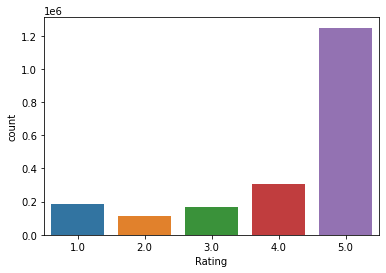

In [10]:
import seaborn as sns
sns.countplot(x='Rating',data=df)
plt.show()

In [11]:
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

In [12]:
#outlier for rating feature in the dataset

outliers = find_outliers_IQR(df['Rating'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))



number of outliers: 296818
max outlier value: 2.0
min outlier value: 1.0


In [13]:
#outlier for timestamp feature in dataset

outliers = find_outliers_IQR(df['Timestamp'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))


number of outliers: 154846
max outlier value: 1288396800
min outlier value: 908755200


In [14]:
# Data frame with calculated fields and measures

unique_products_list = df.ProductId.unique()
data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list], \
                          'Unreliability': unreliability[unique_products_list]})
data_model.head()

,Rating,Count,Unreliability
ProductId,,,
0205616461,5.0,1,0.000000
0558925278,4.0,2,0.816497
0733001998,4.0,1,0.000000
0737104473,1.0,1,0.000000
0762451459,5.0,1,0.000000


In [15]:
# Removing outliers and improbable data points

data_model = data_model[data_model.Count > 50][data_model.Count < 1001].copy()
print(data_model.shape)

(6763, 3)


In [16]:
# Normalization function to range 0 - 10

def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [17]:
data_model_norm = normalize(data_model)
data_model_norm.head()

,Rating,Count,Unreliability
ProductId,,,
9790790961,7.991506,0.201913,6.557281
B00004TMFE,5.713948,0.913921,7.953812
B00004TUBL,8.992153,5.387885,4.449336
B00004TUBV,7.984827,1.275239,6.268773
B00004U9UY,9.244724,1.009564,4.066169


### Step 4: Apply Recommendations algorithms to the dataset

In [18]:
# Setting up the model

# Recommend 20 similar items
from sklearn.neighbors import KNeighborsClassifier
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = data_model_norm[['Count', 'Rating', 'Unreliability']].values

#Training labels
labels = data_model_norm.index.values

print("Data points: ", data_points)
print('\n')
print("Labels: ",labels)

Data points:  [[0.20191286 7.99150579 6.55728119]
 [0.91392136 5.71394752 7.95381168]
 [5.38788523 8.99215344 4.44933587]
 ...
 [0.21253985 9.6117244  2.18485285]
 [3.04994687 9.33120102 2.47548276]
 [4.64399575 8.69505981 5.78555039]]


Labels:  ['9790790961' 'B00004TMFE' 'B00004TUBL' ... 'B00KWE08Q0' 'B00KWFDBKE'
 'B00L5JHZJO']


In [19]:
engine.fit(data_points, labels)

KNeighborsClassifier(n_neighbors=20)

### Step 5: Give recommendations and interpret your result

In [20]:
# Enter product ID to get a list of 20 recommended items

# User entered value
product_id = 'B00004TUBL'

product_data = [data_model_norm.loc[product_id][['Count', 'Rating', 'Unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=20, return_distance=False)

# List of product IDs form the indexes

products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)


Recommended products: 
[Index(['B00004TUBL', 'B0000AFUTL', 'B00CNOUZE2', 'B008TBTA6C', 'B009GIOVKC',
       'B000ODNSR0', 'B000NWGCZ2', 'B00D6EDGYE', 'B002TPQPEE', 'B0013TM9UQ',
       'B004XA81ZE', 'B009GEUPDS', 'B00132ZG3U', 'B00H93NJLS', 'B000OQ2DL4',
       'B000F35R00', 'B0018DAUKI', 'B001DKQ3O8', 'B001ET77NY', 'B00178TVXG'],
      dtype='object', name='ProductId')]


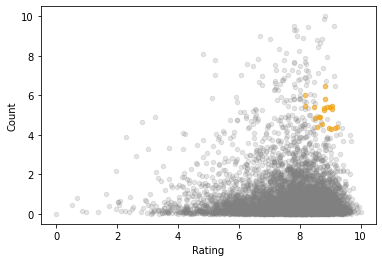

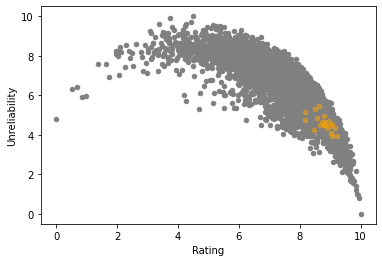

In [21]:
# Showing recommended products

ax = data_model_norm.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.20)
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Count',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = data_model_norm.plot(kind='scatter', x='Rating', y='Unreliability', color='grey')
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Unreliability',\
                                                   color='orange', alpha=0.5, ax=ax2)
plt.show()
